# IMPORTING LIBRARIES

In [1]:
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import time

2023-09-10 11:07:28.840397: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 11:07:28.876947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 11:07:28.877745: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 11:07:29.550499: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# IMPORTING MNIST DATA

In [2]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data()

# VISUALIZING THE DATA

In [3]:
X_train.shape

(60000, 28, 28)

/tmp/ipykernel_49480/2495820623.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


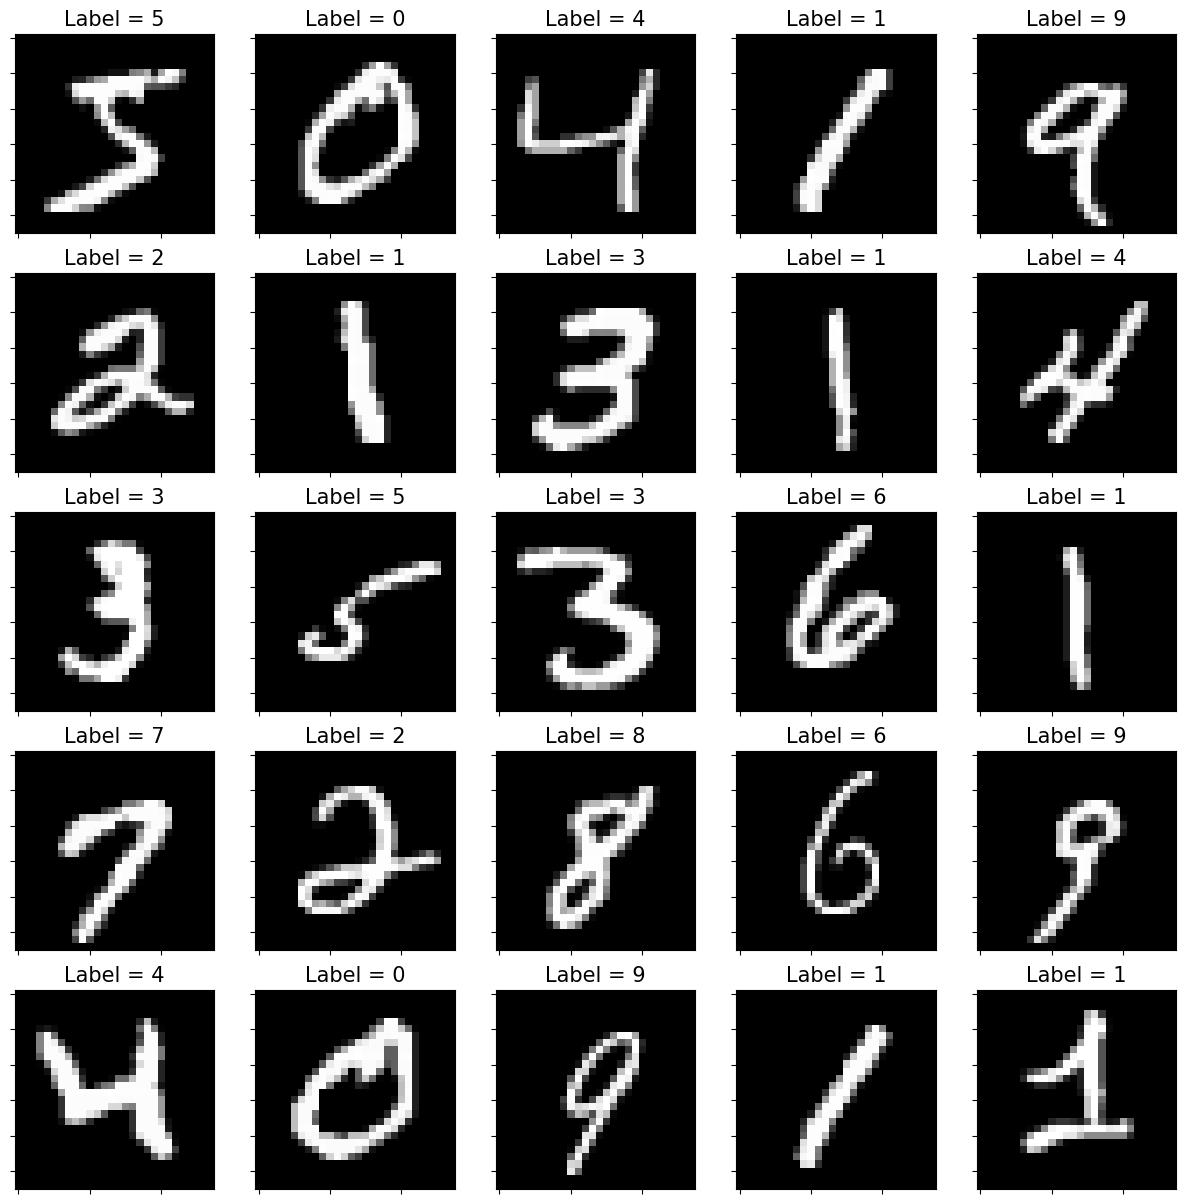

In [4]:
fig,axes = plt.subplots(nrows=5,ncols=5,figsize=(15,15))
row =0
col = 0
for i in range(25):
    if col in [4,9,14,19]:
        axes[row][col].imshow(X_train[i],cmap="gray")
        axes[row][col].set_title("Label = "+str(y_train[i]),fontsize=15)
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        row+=1
        col = 0
    else:
        axes[row][col].imshow(X_train[i],cmap="gray")
        axes[row][col].set_title("Label = "+str(y_train[i]),fontsize=15)
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        col+=1
fig.show()

# SHUFFLING AND MAKING DATASET

In [5]:
def make_dataset(X_train):
    images = X_train.reshape((-1,28,28,1))/255
    return np.where(images>0.5,1.0,0.0).astype(np.float32)

In [6]:
train_images = make_dataset(X_train)
test_images = make_dataset(X_test)

In [7]:
def make_tensor_data(data,shuffle_size,batch_size):
    return tf.data.Dataset.from_tensor_slices(data).shuffle(shuffle_size).batch(batch_size)

In [8]:
train_dataset = make_tensor_data(train_images,train_images.shape[0],32)
test_dataset = make_tensor_data(test_images,test_images.shape[0],32)

2023-09-10 11:07:41.832880: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# MODEL BUILDING

## ENCODER BUILDING

In [9]:
class encoder:
    def __init__(self,latent_dim,img_shape,conv_info = {}):
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential()
        self.encoder.add(tf.keras.layers.InputLayer(input_shape = img_shape))
        if conv_info == []:
            for filters,kernel in  {32:3,64:3}.items():
                self.encoder.add(tf.keras.layers.Conv2D(filters,kernel,strides=(2,2),activation="relu"))
        else:
            for filters,kernel in conv_info.items():
                self.encoder.add(tf.keras.layers.Conv2D(filters,kernel,strides=(2,2),activation="relu"))
        self.encoder.add(tf.keras.layers.Flatten())
        self.encoder.add(tf.keras.layers.Dense(self.latent_dim+self.latent_dim))

In [10]:
encoder1 = encoder(7,(28,28,1))

## DECODER MODEL

In [11]:
class decoder:
    def __init__(self,latent_dim):
        self.latent_dim = latent_dim
        self.decoder = tf.keras.Sequential()
        self.decoder.add(tf.keras.layers.InputLayer(input_shape = (latent_dim,)))
        self.decoder.add(tf.keras.layers.Dense(7*7*32,activation="relu"))
        self.decoder.add(tf.keras.layers.Reshape(target_shape = (7,7,32)))
        self.decoder.add(tf.keras.layers.Conv2DTranspose(64,3,strides = 2,activation="relu",padding="same"))
        self.decoder.add(tf.keras.layers.Conv2DTranspose(32,3,strides = 2,activation="relu",padding="same"))
        self.decoder.add(tf.keras.layers.Conv2DTranspose(1,3,strides = 1,padding="same"))

In [12]:
decoder1 = decoder(7)

## COMBINING THE ARCHITECTURES TO FORM THE FINAL CVAR

In [27]:
class CVAR(tf.keras.Model):
    def __init__(self,latent_dim,image_shape):
        super(CVAR,self).__init__()
        self.latent_dim = latent_dim
        self.encoder = encoder(latent_dim,image_shape).encoder
        self.decoder = decoder(latent_dim).decoder
    @tf.function
    def sample(self,eps = None):
        if eps==None:
            eps = tf.random.normal(shape=(100,self.latent_dim))
        return self.decode(eps,apply_sigmoid = True)
    def encode(self,x):
        mean,logvar = tf.split(self.encoder(x),num_or_size_splits=2,axis=1)
        return mean,logvar
    def reparameterize(self,mean,logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar*.5)+mean
    def decode(self,x,apply_sigmoid = False):
        logits = self.decoder(x)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

# CREATING LOSS FUNCTINS FOR THE MODEL

In [65]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

In [66]:
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [67]:
@tf.function
def train_step(model,x,optimizer):
    with tf.GradientTape() as Tape:
        loss = compute_loss(model,x)
    gradients = Tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))

# TRAINING THE MODEL

In [68]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model = CVAR(2,(28,28,1))

In [69]:
def predict(model,epoch,test_sample,save = True):
    mean,logvar = model.encode(test_sample)
    z = model.reparameterize(mean,logvar)
    predictions = model.sample(z)
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    if save:
        plt.savefig("./generation while training/image at epoch {:04d}.png".format(epoch))
    plt.show()

In [70]:
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:16,:,:,:]

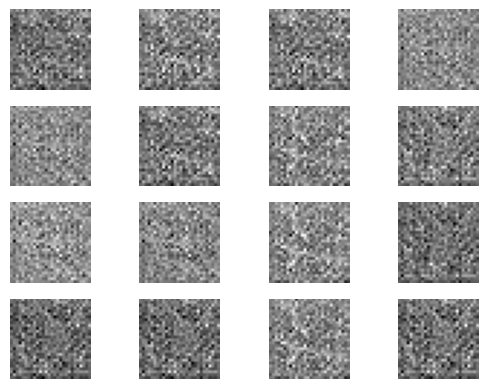

In [71]:
predict(test_sample=test_sample,model=model,epoch=0,save = False)

In [72]:
def fit(model,train_dataset,test_dataset,test_sample,optimizer,epochs = 10,image_number = 16):
    for epoch in range(1,epochs+1):
        start_time = time.time()
        for train_x in train_dataset:
            train_step(model,train_x,optimizer)
        end_time = time.time()
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model,test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
        predict(model,epoch,test_sample)

Epoch: 20, Test set ELBO: -165.6991424560547, time elapse for current epoch: 20.091317176818848


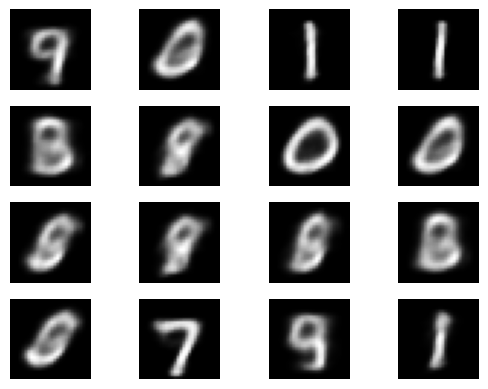

In [73]:
fit(model,train_dataset,test_dataset,test_sample,optimizer,epochs=20)

In [49]:
for test_sample in test_dataset.take(100):
    test_sample = test_sample[:16,:,:,:]

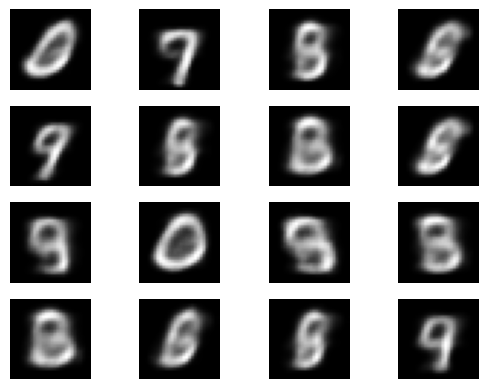

In [50]:
predict(model,1,test_sample)